# Question Answering with Langchain and Mistral

<a target="_blank" href="https://colab.research.google.com/github/elastic/elasticsearch-labs/blob/main/notebooks/generative-ai/question-answering.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 대화형 노트북은 Langchain을 사용하여 가상의 직장 문서를 구절로 분할하고 "multilingual-e5-base"를 사용하여 이러한 구절을 임베딩으로 변환하고 Elasticsearch에 저장합니다.

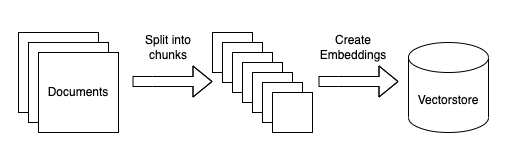

그런 다음 질문을 하면 벡터 스토어에서 관련 구절을 검색하고 langchain과 Mistral LLM을 사용하여 질문에 대한 요약을 제공합니다.

## Install packages and import modules


In [2]:
# install packages
%pip install -U langchain elasticsearch tiktoken sentence_transformers llama-cpp-python wget

Note: you may need to restart the kernel to use updated packages.


In [3]:
# import modules
from getpass import getpass
from langchain.vectorstores import ElasticsearchStore
from langchain.embeddings import HuggingFaceEmbeddings
from urllib.request import urlopen
from langchain.text_splitter import CharacterTextSplitter
from langchain.llms import LlamaCpp
from langchain.chains import RetrievalQA
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
import json
import os
import wget

cwd = os.getcwd()

## Connect to Elasticsearch

[ElasticsearchStore](https://api.python.langchain.com/en/latest/Vectorstores/langchain.Vectorstores.elasticsearch.ElasticsearchStore.html)를 사용하여 Elastic Cloud 배포에 연결하겠습니다. 이렇게 하면 데이터를 쉽게 생성하고 색인화하는 데 도움이 됩니다. 

ElasticsearchStore 인스턴스에서 임베딩을 [HuggingFaceEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.huggingface.HuggingFaceEmbeddings.html)로 설정하여 해당 텍스트와 Elasticsearch 인덱스 이름을 임베드합니다. 임베딩 모델은 [intfloat/multilingual-e5-base](https://huggingface.co/intfloat/multilingual-e5-base) 모델을 사용합니다.

In [4]:
# set elastic client info
ES_URL = "https://localhost:9200" #input('Elasticsearch URL(ex:https://127.0.0.1:9200): ')
ES_USER = "elastic" 
ES_USER_PASSWORD = "elastic" #getpass('elastic user PW: ')
CERT_PATH = "/home/wonseop/es/8.11.1/kibana-8.11.1/data/ca_1700913435542.crt" #input('Elasticsearch pem 파일 경로: ')
# pem 생성 방법: https://cdax.ch/2022/02/20/elasticsearch-python-workshop-1-the-basics/

In [5]:
from elasticsearch import Elasticsearch

client = Elasticsearch(
    ES_URL,
    basic_auth=(ES_USER, ES_USER_PASSWORD),
    ca_certs=CERT_PATH
)

if client.indices.exists(index="workplace_index"):
    client.indices.delete(index="workplace_index")

In [6]:
import os
cwd = os.getcwd()

if os.path.isdir(cwd + "/models"):
    pass
else:
    os.mkdir(cwd + "/models")

In [7]:
os.chdir(cwd + "/models")

try :
    os.system("git lfs install & git clone https://huggingface.co/intfloat/multilingual-e5-base")
except:
    print('이미 모델이 존재합니다.')

os.chdir(cwd)

fatal: destination path 'multilingual-e5-base' already exists and is not an empty directory.


In [8]:
embeddings = HuggingFaceEmbeddings(model_name=cwd + "/models/multilingual-e5-base", model_kwargs = {'device': 'cpu'} )

vector_store = ElasticsearchStore(
    es_connection = client,
    index_name="workplace_index",
    embedding=embeddings
)

Updated git hooks.
Git LFS initialized.


/home/wonseop/miniconda3/envs/genai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download the dataset 

샘플 데이터 세트를 다운로드하고 문서를 역직렬화해 보겠습니다.

In [9]:
url = "https://raw.githubusercontent.com/elastic/elasticsearch-labs/main/example-apps/chatbot-rag-app/data/data.json"

response = urlopen(url)

workplace_docs = json.loads(response.read())


### Split Documents into Passages

검색 특이성(retrieval specificity)을 향상하고 최종 질문 답변 프롬프트의 컨텍스트 창 내에서 여러 구절을 제공할 수 있도록 문서를 구절로 청크할 것입니다.

여기서는 400개의 토큰이 겹치는 800개의 토큰 구절로 문서를 청크합니다.

여기서는 간단한 스플리터를 사용하고 있지만 Langchain은 컨텍스트 손실 가능성을 줄이기 위해 고급 스플리터를 제공합니다.

In [10]:
metadata = []
content = []

for doc in workplace_docs:
  content.append(doc["content"])
  metadata.append({
      "name": doc["name"],
      "summary": doc["summary"]
  })

text_splitter = CharacterTextSplitter(chunk_size=800, chunk_overlap=400)
docs = text_splitter.create_documents(content, metadatas=metadata)

Created a chunk of size 866, which is longer than the specified 800
Created a chunk of size 1120, which is longer than the specified 800


## Index data into elasticsearch

이제 각 문서를 800개의 청크 크기로 분할했으므로 이제 [ElasticsearchStore.from_documents](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.elasticsearch.ElasticsearchStore.html#langchain.vectorstores.elasticsearch.ElasticsearchStore.from_documents)를 사용하여 Elasticsearch에 데이터를 인덱싱하겠습니다.

In [11]:
documents = vector_store.from_documents(
    docs, 
    embeddings, 
    es_connection=client, 
    index_name="workplace_index",
)

## Asking a question

이제 Elasticsearch에 구절이 저장되었으므로 관련 구절을 얻기 위해 질문을 할 수 있습니다.

In [12]:
import wget

if os.path.isfile(cwd + "/models/openbuddy-mistral-7b-v13.Q4_K_M.gguf"):
    pass
else:
    wget.download("https://huggingface.co/TheBloke/openbuddy-mistral-7B-v13-GGUF/resolve/main/openbuddy-mistral-7b-v13.Q4_K_M.gguf", out=cwd + "/models/")

In [13]:
retriever = vector_store.as_retriever()

n_gpu_layers = None  # Metal set to 1 is enough.
n_batch = 1  # Should be between 1 and n_ctx, consider the amount of RAM of your Apple Silicon Chip.
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

# Make sure the model path is correct for your system!
llm = LlamaCpp(
    # https://huggingface.co/TheBloke/openbuddy-mistral-7B-v13-GGUF
    model_path = cwd + "/models/openbuddy-mistral-7b-v13.Q4_K_M.gguf",
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
    n_ctx=4096,

    # https://www.reddit.com/r/LocalLLaMA/comments/1343bgz/what_model_parameters_is_everyone_using/
    temperature=0.75,
    top_k=1,
    top_p=1,

    # max_tokens=2048,
    verbose=True,
    f16_kv=True,  # MUST set to True, otherwise you will run into problem after a couple of calls
    callback_manager=callback_manager,
)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)



llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from /home/wonseop/Projects/es-lab-kr/notebooks/generative-ai/models/openbuddy-mistral-7b-v13.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 36608,     1,     1 ]
llama_model_loader: - tensor    1:              blk.0.attn_q.weight q4_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    2:              blk.0.attn_k.weight q4_K     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_v.weight q6_K     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    4:         blk.0.attn_output.weight q4_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_gate.weight q4_K     [  4096, 14336,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.ffn_up.weight q4_K     [  4096, 14336,     1,     1 ]
llama_model_loader: - tensor    7:         

In [14]:
ans = qa({"query": "What does NASA stand for?"})

print("---- Answer ----")
print(ans["result"])
print("---- Sources ----")
for doc in ans["source_documents"]:
  print(doc.metadata["name"])
  print(doc.page_content)